## Generating full off-shell kinematics

#### Background

Simulations for LHC physics is a major computational task at the experiment, and will become more computationally intensive in the coming years, so if ML techniques can speed up some aspects of this then it would be very useful. The process we are studying is a leptonic $t\bar{t}$-decay: $t \bar{t} \rightarrow W^- \;\bar{b}\; W^+ \;b \rightarrow (\ell \bar{\nu}) \; \bar{b} \; (\bar{\ell} \nu) \; b$<br>
Here, the computational difficulty lays in accuratly modeling full off-shell effects. ML could help there, however the phase space containing on + off-shell effects is a multiresonant phase space in 24 dimensions. Instead of learning this phase space from scratch we make use of a CFM model mapping unpaired samples from on-shell (here on) to on+off-shell (here off) i.e. using our physics knowledge to make an educated guess of our latent space.

#### Interesting papers

- Kicking it Off(-shell) with Direct Diffusion<br>
    *Anja Butter, Tomas Jezo, Michael Klasen, Mathias Kuschick, Sofia Palacios Schweitzer, Tilman Plehn*<br>
    https://arxiv.org/pdf/2311.17175.pdf
- Flow Matching for Generative Modeling<br>
  *Yaron Lipman, Ricky T. Q. Chen, Heli Ben-Hamu, Maximilian Nickel, Matt Le*<br>
  https://arxiv.org/pdf/2210.02747.pdf

#### Outline

- Imports
- Loading the data
- Study the data
- Preprocessing
- Defining the diffusion model
- Training the model
- Study the results


In [7]:
import math
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
from torchdiffeq import odeint
import matplotlib
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [8]:
# Load off-shell and on-shell data
train_data_off = np.load("offshell_trn_data.npy")
val_data_off = np.load("offshell_val_data.npy")
test_data_off = np.load("offshell_tst_data.npy")

train_data_on = np.load("onshell_trn_data.npy")
val_data_on = np.load("onshell_val_data.npy")
test_data_on = np.load("onshell_tst_data.npy")

In [9]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [10]:
print(device)

cpu


In [11]:
train_data_off.shape, val_data_off.shape, test_data_off.shape

((500000, 12), (250000, 12), (250000, 12))

In [12]:
train_data_on.shape, val_data_on.shape, test_data_on.shape

((500000, 12), (250000, 12), (250000, 12))

We focus on half of the physics phase space, i.e. we only look at the $t$-decay. Hence, each element of the data has 12 entries, corresponding to the 4-momenta of the $\bar{\nu}$, $\ell$ and $\bar{b}$ respectively.

Each entry has the form $[E_\bar{\nu}, p_{x,\bar{\nu}}, p_{y,\bar{\nu}}, p_{z,\bar{\nu}}, E_\ell, p_{x,\ell}, p_{y,\ell}, p_{z,\ell},E_\bar{b}, p_{x,\bar{b}}, p_{y,\bar{b}}, p_{z,\bar{b}} ]$.

The most intersting and difficult correlations are the resonance masses form the $W$-Boson decay and the $t$-quark decay. 

In [13]:
def get_obs(events):
    nu_4m = events[...,0:4]
    l_4m = events[...,4:8]
    b_4m = events[...,8:]
    t_4m = nu_4m + l_4m + b_4m

    t_im = np.sqrt(t_4m[...,0]**2 - t_4m[...,1]**2 - t_4m[...,2]**2 - t_4m[...,3]**2)
    t_pt = np.sqrt(t_4m[...,1]**2 + t_4m[...,2]**2)
    
    W_4m = nu_4m + l_4m
    W_im = np.sqrt(W_4m[...,0]**2 - W_4m[...,1]**2 - W_4m[...,2]**2 - W_4m[...,3]**2)
    W_pt = np.sqrt(W_4m[...,1]**2 + W_4m[...,2]**2)


    return t_im, t_pt, W_im, W_pt

Let's get the invariant mass and the transverse momentum of the $t$-quark and the $W$-Boson for the off- and on-shell test dataset

In [14]:
test_t_ims_off, test_t_pts_off, test_W_im_off, test_W_pts_off = get_obs(test_data_off)
test_t_ims_on, test_t_pts_on, test_W_im_on, test_W_pts_on = get_obs(test_data_on)

Let's plot the invariant mass of the $t$-decay for off- and on-shell data.

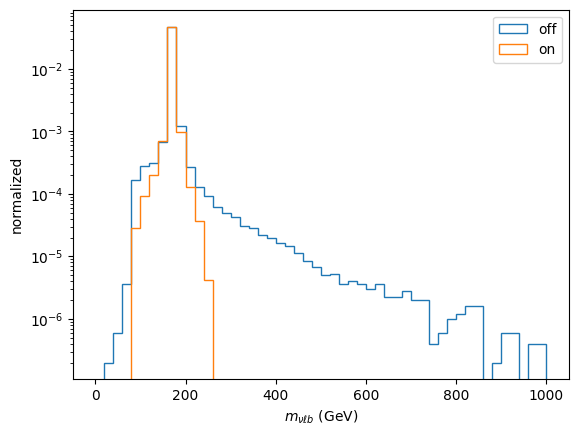

In [15]:
fig, axs = plt.subplots()
axs.hist(test_t_ims_off, density=True, bins=50, histtype="step", range=[0,1000], label="off")
axs.hist(test_t_ims_on, density=True, bins=50, histtype="step", range=[0,1000], label="on")
axs.set_xlabel(r"$m_{\nu \ell b}$ (GeV)")
axs.set_ylabel("normalized")
axs.set_yscale("log")
axs.legend()
plt.show()

Whereas the resonsant structure of both datasets is identical (peak at $m_t =172.5$GeV), we can clearly observe off-shell effects in the right tail of the mass distribution. 

Now, concerning our physical degrees of freedom:<br>
Neutrinos are assumed to be massless, reducing the degrees of freedom to 11.<br>
Furthermore, the lepton's mass (can be muon or electron) will be of a much lower energy scale than the $t \bar{t}$ decay. Hence, it's a valid approximation to set $m_\ell \approx 0$.<br>
Next, we are on parton level which implies that $m_b =4.75$ GeV holds for the $b$-quark. We can therefore, remove an additional degree of freedom.<br>
This leaves us in total with 9 d.o.f.

We can choose a more suitable representation that takes into account the symmetries of our data:
- $p_{T,i} = \sqrt{p_{x,i}^2+p_{y,i}^2}$
- $\eta_i = \text{arctanh}\left(\frac{p_{z,i}}{\sqrt{p_{x,i}^2+p_{y,i}^2+p_{z,i}^2}}\right)$
- $\phi_i = \text{arctan2}(p_{y,i}, p_{x,i})$<br> <br>
where i runs over all three particles.

We know from experience that ML models work best when the input is distributed approximately Gaussian. $\phi_i$ follows a uniform distribution, so we can transform it into something closer to a Gaussian by applying $\text{arctanh}$. We also apply a component-wise normalization step such that the data has a mean of $0$ and a standard deviation of $1$.

Let's write some functions to apply the preprocessing to the training data and invert it for the generated data:

In [16]:
def apply_preprocessing(data_full):
    # neutrino
    pt_nu = np.sqrt(data_full[...,1]**2 + data_full[...,2]**2)
    eta_nu = np.arctanh(data_full[...,3] / np.sqrt(data_full[...,1]**2 + data_full[...,2]**2 + data_full[...,3]**2))
    phi_nu = np.arctanh(np.arctan2(data_full[...,2], data_full[...,1]) / np.pi)
    # lepton
    pt_l = np.sqrt(data_full[...,5]**2 + data_full[...,6]**2)
    eta_l = np.arctanh(data_full[...,7] / np.sqrt(data_full[...,5]**2 + data_full[...,6]**2 + data_full[...,7]**2))
    phi_l = np.arctanh(np.arctan2(data_full[...,6], data_full[...,5]) / np.pi)
    # b-quark
    pt_b = np.sqrt(data_full[...,9]**2 + data_full[...,10]**2)
    eta_b = np.arctanh(data_full[...,11] / np.sqrt(data_full[...,9]**2 + data_full[...,10]**2 + data_full[...,11]**2))
    phi_b = np.arctanh(np.arctan2(data_full[...,10], data_full[...,9]) / np.pi)
    
    
    #Standardize
    data_new = np.stack((pt_nu, eta_nu, phi_nu, pt_l, eta_l, phi_l, pt_b, eta_b, phi_b), axis=-1)
    mean = data_new.mean(0)
    std = data_new.std(0)
    
    data_new = (data_new - mean)/std
    
    return data_new, mean, std

def invert_preprocessing(data_red, mean, std):
    # Undo standardize
    data_red = data_red*std + mean
    #neutrino
    pt_nu = data_red[...,0]
    eta_nu = data_red[...,1]
    phi_nu = np.arctan(data_red[...,2]) * np.pi
    px_nu = pt_nu * np.cos(phi_nu)
    py_nu = pt_nu * np.sin(phi_nu)
    pz_nu = pt_nu * np.sinh(eta_nu)
    E_nu = np.sqrt(px_nu**2 + py_nu**2 + pz_nu**2)
    
    #lepton
    pt_l = data_red[...,3]
    eta_l = data_red[...,4]
    phi_l = np.arctan(data_red[...,5]) * np.pi
    px_l = pt_l * np.cos(phi_l)
    py_l = pt_l * np.sin(phi_l)
    pz_l = pt_l * np.sinh(eta_l)
    E_l = np.sqrt(px_l**2 + py_l**2 + pz_l**2)
    
    #b-quark
    pt_b = data_red[...,6]
    eta_b = data_red[...,7]
    phi_b = np.arctan(data_red[...,8]) * np.pi
    px_b = pt_b * np.cos(phi_b)
    py_b = pt_b * np.sin(phi_b)
    pz_b = pt_b * np.sinh(eta_b)
    E_b = np.sqrt(px_b**2 + py_b**2 + pz_b**2 + 4.75**2)
    
    return np.stack((E_nu, px_nu, py_nu, pz_nu, E_l, px_l, py_l, pz_l, E_b, px_b, py_b, pz_b), axis=-1)

Now we can apply them to the training data and val data

In [17]:
train_data_off, mean, std = apply_preprocessing(train_data_off)
val_data_off, _ , _ = apply_preprocessing(val_data_off)

train_data_on, _, _ = apply_preprocessing(train_data_on)
val_data_on, _ , _ = apply_preprocessing(val_data_on)

As mentioned in the introduction, our ML network of choice for this tasks is a Conditional Flow Matching (CFM) network. It describes the process of a point $x_0 \sim p(x_\text{on})$ diffusing directly (DiDi) into a point $x_1 \sim p(x_\text{off})$ goverend by a velocity field 
\begin{align}
\frac{dx}{dt} = v(x,t).
\end{align}
In principle we could learn this veloctiy field as a regression task using a MSE loss. However, how can we define it? We start by describing the diffusion process by a linear trajectory
\begin{align}
    x (t | x_0, x_1) = (1-t)x_0 + tx_1.
\end{align}
The corresponding veloctiy field yields to
\begin{align}
    v(x,t | x_0, x_1) = x_1 - x_0.
\end{align}
Why is this useful? We want to generate $x_1$, so why are we interested in learning a quantitiy, which is only defined once $x_1$ is known? Well luckily, it can be shown that
\begin{align}
\mathrm{argmin}_\theta \left< (v_\theta(x_t,t) - v(x,t))^2\right>_{x,t \sim p(x,t)} = \mathrm{argmin}_\theta \left< (v_\theta(x,t) - v(x,t|x_0,x_1))^2 \right>_{x_0\sim p(x_0), x_1\sim p(x_1), t\sim U(0,1)},
\end{align}
where $v_\theta(x_t,t)$ is the network output. <br>
Hence, we have all ingredients to cook a tractable loss function. Once we are finished training we can simply solve
\begin{align}
    x_1 = x_0 + \int_0^1 v_\theta(x,t) dt
\end{align}
using a fast ODE-sampler. We can now define the DiDi network class. 

In [20]:
class Didi(nn.Module):
    def __init__(self, 
                 dims,
                 params,
                 data_off,
                 data_on,
                ):
        super().__init__()
        self.dims = dims
        self.params = params       
        
        self.train_data_off = data_off[0]
        self.train_data_on = data_on[0]
        
        self.val_data_off =  data_off[1]
        self.val_data_on =  data_on[1]
        
        
    def init_network(self):
        layers = []
        layers.append(nn.Linear(self.dims+1, self.params["internal_size"]))
        layers.append(nn.ReLU())
        for _ in range(self.params["hidden_layers"]):
            layers.append(nn.Linear(self.params["internal_size"], self.params["internal_size"]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.params["internal_size"], self.dims))
        self.net = nn.Sequential(*layers)
        
        
    def sample(self, x_0):
        self.net.eval()
        batch_size = x_0.size(0)
        dtype = x_0.dtype
        device = x_0.device
        def net_wrapper(t, x_t):
            t = t * torch.ones_like(x_t[:, [0]], dtype=dtype, device=device)
            nn_out = self.net(torch.cat([t, x_t], dim=-1))
            return nn_out
            
        
        x_t = odeint(net_wrapper,
                     x_0,
                     torch.tensor([0,1], dtype=dtype, device=device),
                             atol = 1.e-6,
                             rtol = 1.e-5,
                             method = 'rk4',
                             options= {"step_size": 0.01}
                             )
        
        return x_t[-1]

    
    def train(self, trainloader_off,  trainloader_on, valloader_off, valloader_on):
        n_epochs = self.params["n_epochs"]
        lr = self.params["lr"]
        
        optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, len(trainloader_on)*n_epochs)
        
        t0 = time.time()
        print(f"Training CFM for {n_epochs} epochs with lr {lr}")
        
        self.best_state = self.net.state_dict()
        best_val_loss = 999
        
        for epoch in range(n_epochs):
            losses = []
            val_losses = []
            for batch in zip(trainloader_on, trainloader_off):
                on, off = batch
                optimizer.zero_grad()
                loss = self.batch_loss(on, off)
                if loss < 250:
                    loss.backward()
                    optimizer.step()
                    losses.append(loss.item())
                    scheduler.step()
                else:
                    print("Skipped update, loss is", loss.item())                
              
            with torch.no_grad():
                for batch in zip(valloader_on, valloader_off): 
                    on, off = batch
                    optimizer.zero_grad()
                    loss = self.batch_loss(on, off)
                    val_losses.append(loss.item())
                    
            val_loss = np.array(val_losses).mean()
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.best_state = self.net.state_dict()
            if epoch % int(n_epochs/10) == 0:
                print(f"Finished epoch {epoch} with average loss {np.array(losses).mean()} and val loss {val_loss}")


    def batch_loss(self, x_0, x_1):
        t = torch.rand((x_0.size(0), 1), dtype=x_0.dtype)

        x_t = (1.-t)*x_1 + t*x_0

        
        nn_out = self.net(torch.cat([t.float(), x_t.float()], dim=-1))
        target = (x_1 - x_0)
        loss = ((nn_out - target.float())**2).mean()
        return loss
    
    
    def run(self):

        self.init_network()

        print("Starting training")
        
        train_loader_off = torch.utils.data.DataLoader(torch.Tensor(self.train_data_off),batch_size=self.params["batch_size"], shuffle=True)
        val_loader_off = torch.utils.data.DataLoader(torch.Tensor(self.val_data_off),batch_size=self.params["batch_size"], shuffle=True)
        train_loader_on = torch.utils.data.DataLoader(torch.Tensor(self.train_data_on), batch_size=self.params["batch_size"], shuffle=True)
        val_loader_on = torch.utils.data.DataLoader(torch.Tensor(self.val_data_on), batch_size=self.params["batch_size"], shuffle=False)
        
        self.train(train_loader_off,train_loader_on, val_loader_off, val_loader_on)
        print("----------------------------")
        print("Finished")

Now, let's try to run it. Feel free to play around with the training parameters.

In [31]:
train_params = {"internal_size": 64, "hidden_layers": 3, "n_epochs": 50, "lr": 1.e-3, "batch_size": 10000}



didi = Didi(  9, 
            train_params,
            [train_data_off, val_data_off],
            [train_data_on, val_data_on],
                )

didi.run()

Starting training
Training CFM for 50 epochs with lr 0.001
Finished epoch 0 with average loss 1.9869048357009889 and val loss 1.9288740682601928
Finished epoch 5 with average loss 1.587568266391754 and val loss 1.5882935953140258
Finished epoch 10 with average loss 1.576415798664093 and val loss 1.5700378608703613
Finished epoch 15 with average loss 1.567520558834076 and val loss 1.5665053844451904
Finished epoch 20 with average loss 1.565499839782715 and val loss 1.5637325048446655
Finished epoch 25 with average loss 1.5594058656692504 and val loss 1.5612066221237182
Finished epoch 30 with average loss 1.5620375108718871 and val loss 1.5594921016693115
Finished epoch 35 with average loss 1.5577653098106383 and val loss 1.5578157091140747
Finished epoch 40 with average loss 1.5600835585594177 and val loss 1.5598763561248778
Finished epoch 45 with average loss 1.5578156733512878 and val loss 1.558553466796875
----------------------------
Finished


We finished training and are now ready to sample. For that purpose we feed our network our test on-shell data and hope it will output a sample resembling the distribution of our test off-shell data

In [22]:
with torch.no_grad():
    samples = []
    test_data_on_pp, _ , _ = apply_preprocessing(test_data_on)
    for batch in torch.split(torch.Tensor(test_data_on_pp), 1000):
        sample = didi.sample(batch).cpu().numpy()
        samples.append(sample)
        
samples = np.concatenate(samples, axis=0)
samples = invert_preprocessing(samples, mean, std)
didi_t_im, didi_t_pt, didi_w_im, didi_w_pt = get_obs(samples)

We start by looking at a trivial distribution $E_\nu$. 

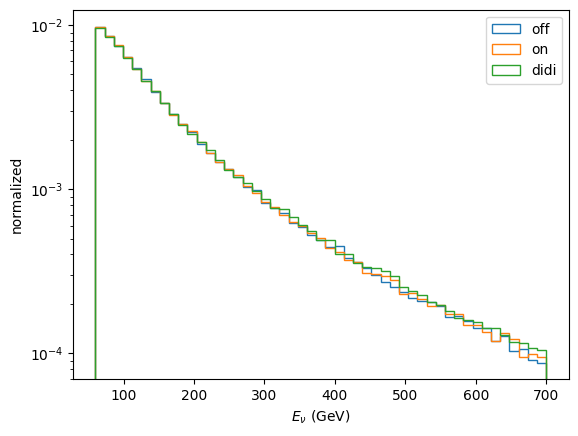

In [28]:
fig, axs = plt.subplots()

bins = np.linspace(60, 700, 50)


axs.hist(test_data_off[:,0], bins=bins, density=True, histtype="step", label="off")
axs.hist(test_data_on[:,0], bins=bins, density=True, histtype="step", label="on")
axs.hist(samples[:,0], bins=bins, density=True, histtype="step", label="didi")

axs.set_xlabel(r"$E_{\nu}$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
axs.set_yscale("log")
plt.show()

There's no visible difference between the on and the off-shell distribution and our model should learn an identiy map.

The hardest possible correlation to learn is the reconstructed top mass as it is a 9 dimensional correlation. Let's see, how our network performs

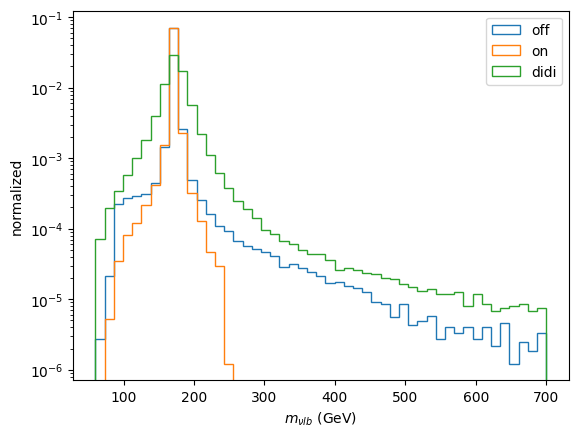

In [29]:
fig, axs = plt.subplots()

bins = np.linspace(60, 700, 50)


axs.hist(test_t_ims_off, bins=bins, density=True, histtype="step", label="off")
axs.hist(test_t_ims_on, bins=bins, density=True, histtype="step", label="on")
axs.hist(didi_t_im, bins=bins, density=True, histtype="step", label="didi")

axs.set_xlabel(r"$m_{\nu l b}$ (GeV)")
axs.set_ylabel("normalized")
axs.legend()
axs.set_yscale("log")
plt.show()

We see, that the network has not learned yet to keep the resonant structure of the on-shell input. Given the limited training data, time and network size this is to be expected. However, we can observe that the characteristic off-shell tails are already reproduced nicely.

It is also intersting to look into event-migration: For a given on-shell event in a given dimension, where will it end up in off-shell phase space. Therefore, we additionally plot migration-plots, plotting essentially the input and the output of our network.

Text(0.5, 1.0, 'Didi migration')

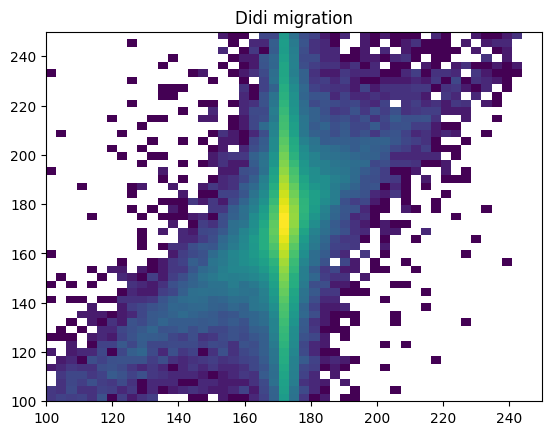

In [30]:
fig, axs = plt.subplots()         
bins = np.linspace(100, 250, 50)

axs.hist2d(test_t_ims_on, didi_t_im, density=True, bins=bins,norm=matplotlib.colors.LogNorm())
axs.set_title(f"Didi migration")